**Final Project - Audit Risk Analysis**

**Introduction**

An auditor’s job is to search through a business’ data and search for risk factors that are associated with fraudulent behaviors. The report of the data we will use in this model is borrowed from the auditor office in India, between the years 2015 and 2016 (https://archive.ics.uci.edu/dataset/475/audit+data). The auditor assessed and calculated fraudulence risk based on audit-paras, environmental conditions reports, firm reputation summary, on-going issues report, profit-value records, loss-value records, follow-up reports etc. We are going to answer the question, “Is our new observation a fraudulent risk?” using Inherent_Risk, and Audit_Risk as our predictors. 
Inherent_Risk: This represents the inherent level of risk associated with the business, considering its industry, size, and other intrinsic factors.
Audit_Risk: This is a metric that combines various risk factors, providing an overall assessment of the potential for fraudulent behavior. It is derived from averaging calculations related to audit-paras, environmental conditions reports, firm reputation summary, ongoing issues report, profit-value records, loss-value records, and follow-up reports.
The dataset contains calculated values for each risk factor, and these values have been averaged to obtain the Audit_Risk. Averaging helps in simplifying complex data, providing a consolidated measure that serves as a key input for predicting fraudulent risks.
The goal is to use the predictors (Inherent_Risk, and Audit_Risk) to determine if a new observation poses a fraudulent risk. This involves leveraging the historical data and patterns derived from the auditor's assessments to make predictions and informed decisions regarding the integrity of the business under consideration.


In [1]:
### Run this cell before continuing.
library(tidyverse)
library(repr)
library(tidymodels)
install.packages("kknn")
library(kknn)
library(dplyr)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

In [2]:
#Reading data into R + Wrangling/Cleaning data

url <- ("https://raw.githubusercontent.com/kathrynida/dsci-100-2023w1-group-16/main/audit_risk.csv")

audit_data <- read_csv(url) |>
    mutate(Risk = as.factor(Risk)) |>
    mutate(LOCATION_ID = as.factor(LOCATION_ID)) |>
    mutate(Risk = fct_recode(Risk, "Suspicious" = "1", "Not Suspicious" = "0"))

audit_data <- audit_data |>
rename_at("LOCATION_ID", ~"Location_ID")

head(audit_data)
tail(audit_data)

New names:
• `Score_B` -> `Score_B...7`
• `Score_B` -> `Score_B...11`
Rows: 776 Columns: 27
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): LOCATION_ID
dbl (26): Sector_score, PARA_A, Score_A, Risk_A, PARA_B, Score_B...7, Risk_B...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Sector_score,Location_ID,PARA_A,Score_A,Risk_A,PARA_B,Score_B...7,Risk_B,TOTAL,numbers,⋯,RiSk_E,History,Prob,Risk_F,Score,Inherent_Risk,CONTROL_RISK,Detection_Risk,Audit_Risk,Risk
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
3.89,23,4.18,0.6,2.508,2.50,0.2,0.500,6.68,5,⋯,0.4,0,0.2,0,2.4,8.574,0.4,0.5,1.7148,Suspicious
3.89,6,0.00,0.2,0.000,4.83,0.2,0.966,4.83,5,⋯,0.4,0,0.2,0,2.0,2.554,0.4,0.5,0.5108,Not Suspicious
3.89,6,0.51,0.2,0.102,0.23,0.2,0.046,0.74,5,⋯,0.4,0,0.2,0,2.0,1.548,0.4,0.5,0.3096,Not Suspicious
3.89,6,0.00,0.2,0.000,10.80,0.6,6.480,10.80,6,⋯,0.4,0,0.2,0,4.4,17.530,0.4,0.5,3.5060,Suspicious
3.89,6,0.00,0.2,0.000,0.08,0.2,0.016,0.08,5,⋯,0.4,0,0.2,0,2.0,1.416,0.4,0.5,0.2832,Not Suspicious
3.89,6,0.00,0.2,0.000,0.83,0.2,0.166,0.83,5,⋯,0.4,0,0.2,0,2.0,2.156,0.4,0.5,0.4312,Not Suspicious


Sector_score,Location_ID,PARA_A,Score_A,Risk_A,PARA_B,Score_B...7,Risk_B,TOTAL,numbers,⋯,RiSk_E,History,Prob,Risk_F,Score,Inherent_Risk,CONTROL_RISK,Detection_Risk,Audit_Risk,Risk
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
55.57,18,0.75,0.2,0.150,0.45,0.2,0.090,1.20,5,⋯,0.4,0,0.2,0,2,1.640,0.4,0.5,0.3280,Not Suspicious
55.57,9,0.49,0.2,0.098,0.40,0.2,0.080,0.89,5,⋯,0.4,0,0.2,0,2,1.578,0.4,0.5,0.3156,Not Suspicious
55.57,16,0.47,0.2,0.094,0.37,0.2,0.074,0.84,5,⋯,0.4,0,0.2,0,2,1.568,0.4,0.5,0.3136,Not Suspicious
55.57,14,0.24,0.2,0.048,0.04,0.2,0.008,0.28,5,⋯,0.4,0,0.2,0,2,1.456,0.4,0.5,0.2912,Not Suspicious
55.57,18,0.20,0.2,0.040,0.00,0.2,0.000,0.20,5,⋯,0.4,0,0.2,0,2,1.440,0.4,0.5,0.2880,Not Suspicious
55.57,15,0.00,0.2,0.000,0.00,0.2,0.000,0.00,5,⋯,0.4,0,0.2,0,2,1.464,0.4,0.5,0.2928,Not Suspicious


In [3]:
#Tidying Data - we removed SAFIDON, NUH, and LOHARU because they were outliers and did not match the format 
#of the other locations

focused_audit_data <- audit_data |>
    select(Location_ID, Inherent_Risk, Audit_Risk, Risk) |>
    filter(Location_ID != "SAFIDON" &  Location_ID != "NUH" & Location_ID != "LOHARU")

head(focused_audit_data)
tail(focused_audit_data)

Location_ID,Inherent_Risk,Audit_Risk,Risk
<fct>,<dbl>,<dbl>,<fct>
23,8.574,1.7148,Suspicious
6,2.554,0.5108,Not Suspicious
6,1.548,0.3096,Not Suspicious
6,17.530,3.5060,Suspicious
6,1.416,0.2832,Not Suspicious
6,2.156,0.4312,Not Suspicious


Location_ID,Inherent_Risk,Audit_Risk,Risk
<fct>,<dbl>,<dbl>,<fct>
18,1.640,0.3280,Not Suspicious
9,1.578,0.3156,Not Suspicious
16,1.568,0.3136,Not Suspicious
14,1.456,0.2912,Not Suspicious
18,1.440,0.2880,Not Suspicious
15,1.464,0.2928,Not Suspicious


In [4]:
#creating training_set and testing_set in order to train and test our classifier later on
set.seed(123)

audit_data_split <- initial_split(focused_audit_data, prop = 0.75, strata = Risk)

audit_training <- training(audit_data_split)
audit_testing <- testing(audit_data_split)

head(audit_training)
head(audit_testing)

Location_ID,Inherent_Risk,Audit_Risk,Risk
<fct>,<dbl>,<dbl>,<fct>
6,1.5480,0.30960,Not Suspicious
6,2.1560,0.43120,Not Suspicious
8,4.3720,0.87440,Not Suspicious
8,1.9060,0.38120,Not Suspicious
8,1.5694,0.31388,Not Suspicious
3,1.6100,0.32200,Not Suspicious


Location_ID,Inherent_Risk,Audit_Risk,Risk
<fct>,<dbl>,<dbl>,<fct>
6,2.554,0.5108,Not Suspicious
6,1.416,0.2832,Not Suspicious
7,31.774,6.3548,Suspicious
8,17.206,3.4412,Suspicious
37,14.492,2.8984,Suspicious
37,2.330,0.4660,Not Suspicious


In [5]:
#Preliminary exploratory data analysis: summarizing data to report number of observations in each class
#(suspicious vs non-suspicious) and the percentage each class of data takes up out of the whole data set
#within each location
row_number <- nrow(focused_audit_data)

location_risk <- audit_training |>
    group_by(Location_ID, Risk) |>
    summarize(count = n(),
          percentage = n()/row_number *100)

head(location_risk)

`summarise()` has grouped output by 'Location_ID'. You can override using the
`.groups` argument.


Location_ID,Risk,count,percentage
<fct>,<fct>,<int>,<dbl>
1,Not Suspicious,2,0.2587322
1,Suspicious,8,1.0349288
11,Not Suspicious,10,1.2936611
11,Suspicious,9,1.1642950
12,Not Suspicious,27,3.4928849
12,Suspicious,15,1.9404916


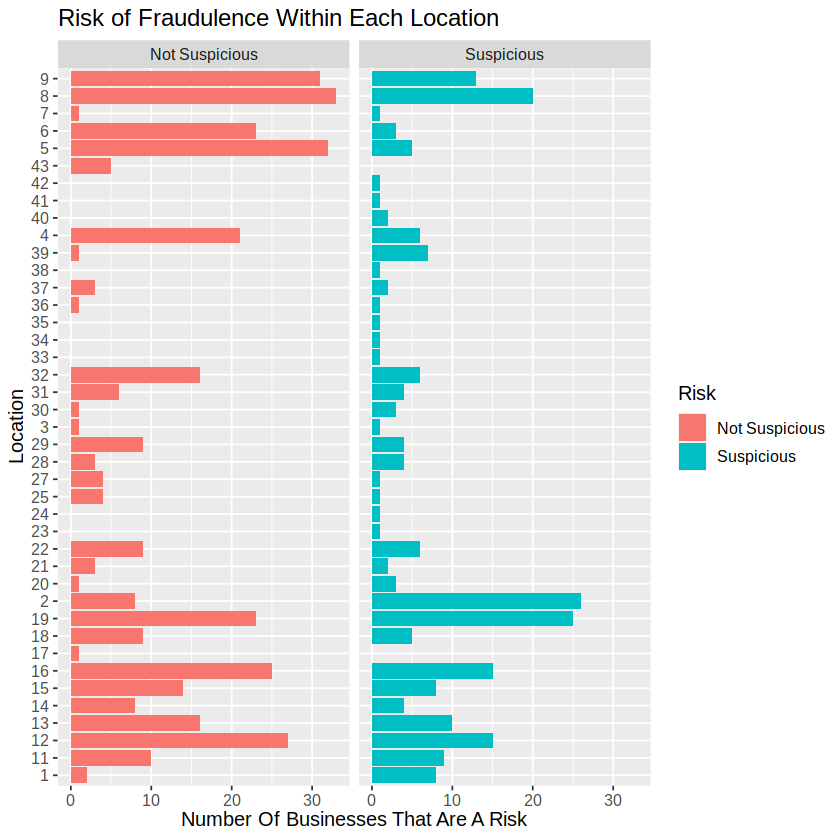

In [6]:
#Preliminary exploratory data analysis: A visual to show the amount of suspicious businesses and non-suspicious 
#businesses in each location

location_risk_plot <- location_risk |>
    ggplot(aes(x = count, y = Location_ID, fill = Risk)) +
    geom_bar(stat = "identity") +
    labs(x = "Number Of Businesses That Are A Risk", y = "Location", fill = "Risk") +
    ggtitle("Risk of Fraudulence Within Each Location") + 
    theme(text = element_text(size = 12)) +
    facet_grid(cols = vars(Risk))

location_risk_plot

This table comparing location to the number of businesses that are a risk is used to demonstrate how certain locations are associated with more fraudulent behaviour than others. For example, locations 2 and 19 show the highest amount of fraudulent behaviour. However, 19 also shows to have a high number of businesses that do not show fraudulent behaviour. This result is most likely due to a high number of businesses in the area, meaning there are too many to determine if this location is a contributor to fraudulence. While location can be a good indicator, as some areas may be associated with more crime due to factors such as the people living in the area and their wealth, it is not the most reliable variable to use during our analysis. Therefore, we will not use Location ID in our classification model.

In [7]:
#shows the relationship between inherent risk and the overall risk of fraudulence
inherent_vs_risk <- audit_training |>
    group_by(Risk) |>
    summarize(Inherent_Risk = mean(Inherent_Risk))

inherent_vs_risk

Risk,Inherent_Risk
<fct>,<dbl>
Not Suspicious,1.927432
Suspicious,39.799807


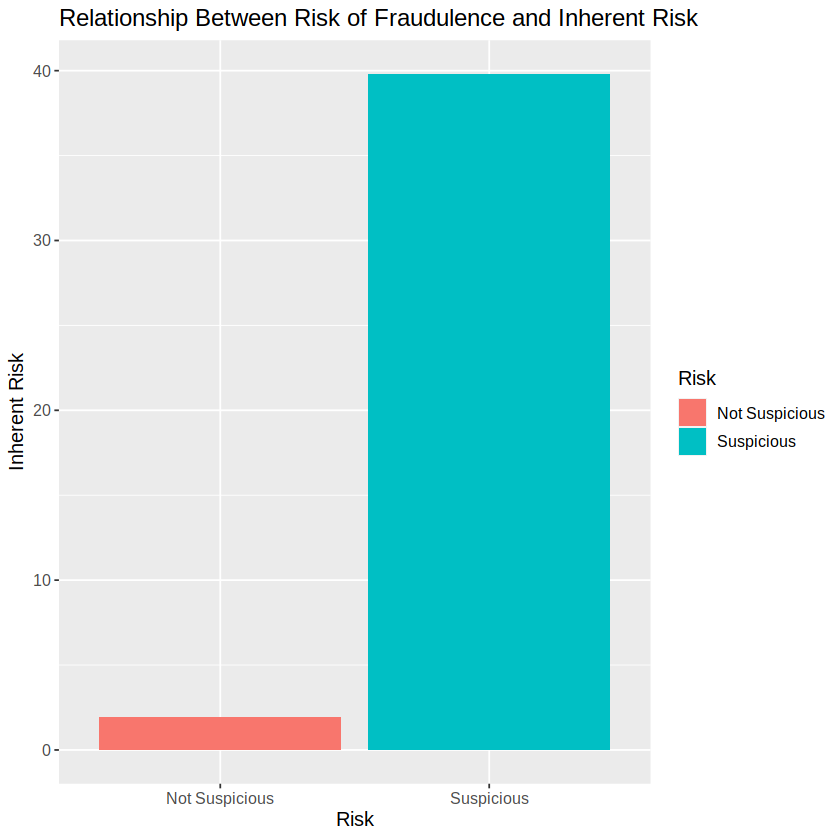

In [8]:
#visualizes the significant increase in average inherent risk in suspicious businesses compared 
#to non-suspicious businesses

inherent_vs_risk_plot <- inherent_vs_risk |>
    ggplot(aes(x = Risk, y = Inherent_Risk, fill = Risk)) +
    geom_bar(stat = "identity") +
    labs(x = "Risk", y = "Inherent Risk", fill = "Risk") +
    ggtitle("Relationship Between Risk of Fraudulence and Inherent Risk") +
    theme(text = element_text(size = 12))

inherent_vs_risk_plot

Inherent risk is compared to overall risk above. This demonstrates how error or a mistaken omission is included in documentation and how this relates to overall risk of fraudulence. The results from the table show that high amounts of inherent risk has a strong positive relationship with overall risk of fraudulence. Therefore, we could predict that businesses that show a high number of errors in their financial statements are suspicious of fraudulence. Due to these results, inherent risk could be considered a reliable factor in identifying fraudulent companies, which is why we chose it as one of our predictors.

In [9]:
#Shows the relationship between audit risk and overall risk of fraudulence.
audit_risk_vs_risk <- audit_training |>
    group_by(Risk) |>
    summarize(Audit_Risk = mean(Audit_Risk))

audit_risk_vs_risk

Risk,Audit_Risk
<fct>,<dbl>
Not Suspicious,0.4103389
Suspicious,14.9500667


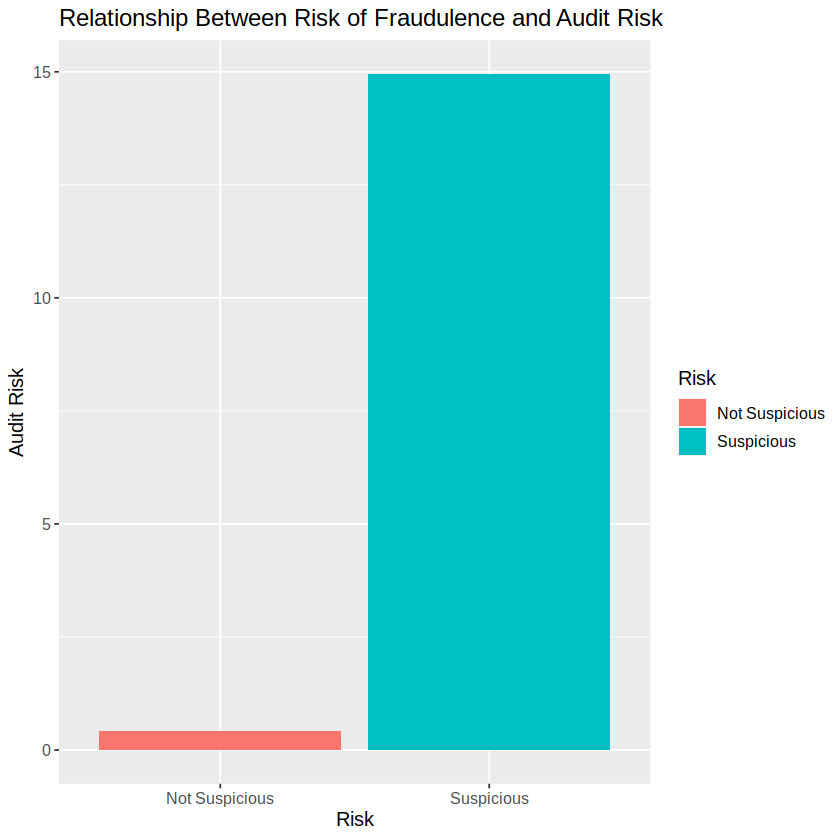

In [10]:
#Plotting audit_risk_vs_risk to provide a visual of the relationship between audit risk and overall risk 
#of fraudulence
audit_risk_vs_risk_plot <- audit_risk_vs_risk |>
ggplot(aes(x = Risk, y = Audit_Risk, fill = Risk)) +
geom_bar(stat = "identity") +
labs(x = "Risk", y = "Audit Risk", fill = "Risk") +
ggtitle("Relationship Between Risk of Fraudulence and Audit Risk") +
theme(text = element_text(size = 12))

audit_risk_vs_risk_plot

The above table shows the relationship between audit risk and overall fraudulence risk. As to be expected, high audit risk is associated with high fraudulence risk shown in the table above, showing a strong positive relationship between these 2 variables. Results from this table show us that Audit Risk is also a good indicator of whether a company is fraudulent or not, which is why audit risk is an important variable to include in our analysis and is chosen as one of our predictors.

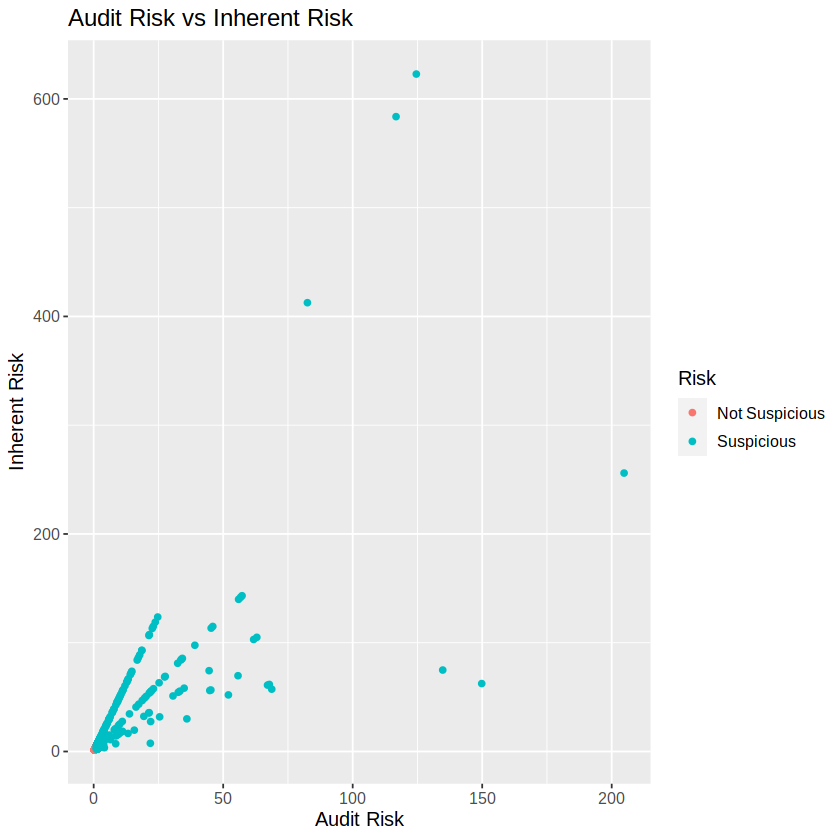

In [19]:
#Plotting audit_vs_inherent_risk. We cannot see any points labeled as "non-suspicious", so the graph is 
#going to have to be scaled. 
audit_risk_vs_inherent_risk <- audit_training |>
ggplot(aes(x = Audit_Risk, y = Inherent_Risk, col=Risk)) + 
geom_point() +
labs(x = "Audit Risk", y = "Inherent Risk", fill = "Risk") +
ggtitle("Audit Risk vs Inherent Risk") + 
theme(text = element_text(size = 12)) 

audit_risk_vs_inherent_risk

Warning message:
“Removed 103 rows containing missing values (`geom_point()`).”


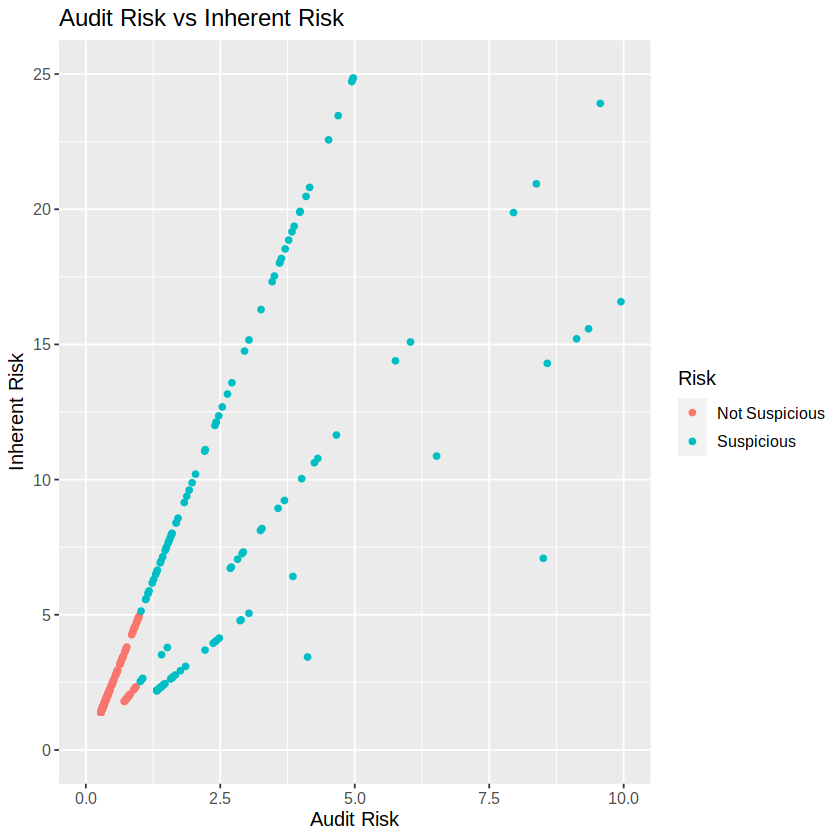

In [20]:
#This plot is similar to the one above except it was scaled to take a closer look at the relationship 
#between audit risk and inherent risk

audit_risk_vs_inherent_risk <- audit_training |>
ggplot(aes(x = Audit_Risk, y = Inherent_Risk, col=Risk)) + 
geom_point() +
labs(x = "Audit Risk", y = "Inherent Risk", fill = "Risk") +
ggtitle("Audit Risk vs Inherent Risk") + 
theme(text = element_text(size = 12)) +
scale_x_continuous(limits = c(0, 10)) +
scale_y_continuous(limits = c(0, 25))


audit_risk_vs_inherent_risk

#As we can tell from the graph, the value for Risk would start to change dependably as Audit Risk is around
#2.18 and when Inherent_Risk is around 5. We also see that Audit Risk and Inherent Risk are linearly 
#related on the graph, so we can say that their correlation is strong. It is almost impossible that high 
#value of one variable would have a low value variable corresponding to it. 
     

In [13]:
# Nearest Neighbors Classification Model: the first prediction is with the testing set, the second prediction is for 
# our new business observation
# Let's put Audit_Risk as 2.18 and Inherent_Risk as 5, as the reason is these values seem to be the threshold in 
# determining whether a bsuiness is suspicious or not
# We will be predicting the risk of fraudulence based on our TWO predictors, inherent risk and audit risk. We chose 
# 3 neighbors to begin because it is not too small that it is not considering enough factors and it is odd, so we can
# avoid a tie between the two types of risks
set.seed(9999)

new_business_1 <- tibble(Audit_Risk = 2.18,  
                  Inherent_Risk = 5,
                  Location_ID = 2)

audit_recipe <- recipe(Risk ~ Inherent_Risk + Audit_Risk, audit_training) |>
step_scale(all_predictors()) |>
step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_fun = "rectangular", neighbor = 3) |>
set_engine("kknn") |>
set_mode("classification")

knn_fit <- workflow() |>
add_recipe(audit_recipe) |>
add_model(knn_spec) |>
fit(data = audit_training)

predict_audit <- predict(knn_fit, audit_testing) |>
bind_cols(audit_testing)

predict_new_business <- predict(knn_fit, new_business_1) |>
bind_cols(new_business_1)

predict_audit
predict_new_business

.pred_class,Location_ID,Inherent_Risk,Audit_Risk,Risk
<fct>,<fct>,<dbl>,<dbl>,<fct>
Not Suspicious,6,2.554,0.5108,Not Suspicious
Not Suspicious,6,1.416,0.2832,Not Suspicious
Suspicious,7,31.774,6.3548,Suspicious
⋮,⋮,⋮,⋮,⋮
Not Suspicious,32,3.318,0.6636,Not Suspicious
Not Suspicious,14,4.680,0.9360,Not Suspicious
Not Suspicious,14,1.456,0.2912,Not Suspicious


.pred_class,Audit_Risk,Inherent_Risk,Location_ID
<fct>,<dbl>,<dbl>,<dbl>
Suspicious,2.18,5,2


In [14]:
#the confusion matrix below is used to determine how accurate our original classification model works

confusion_matrix <- predict_audit |>
             conf_mat(truth = Risk, estimate = .pred_class)
confusion_matrix

                Truth
Prediction       Not Suspicious Suspicious
  Not Suspicious            116          0
  Suspicious                  1         77

In [22]:
#Calculating the accuracy of our testing prediction model
set.seed(9999) # DO NOT REMOVE

prediction_accuracy <- predict_audit |>
         metrics(truth = Risk, estimate = .pred_class) |>
         filter(.metric == "accuracy") 

prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9948454


In [16]:
# We will use cross-validation to tune our classifier, which can help us determine the right number of neighbors to use 
#in our nearest neighbors classifier. This step shows the accuracy of each of the 5 vfold classifiers.

audit_vfold <- vfold_cv(audit_training, v = 5, strata = Risk)

knn_fit <- workflow() |>
add_recipe(audit_recipe) |>
add_model(knn_spec) |>
fit_resamples(resamples = audit_vfold) |>
collect_metrics()

knn_fit

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.9982759,5,0.001724138,Preprocessor1_Model1
roc_auc,binary,0.9978261,5,0.002173913,Preprocessor1_Model1


Cross validation has shown us that the average accuracy of the 5 vfolds is 99.4%. Therefore, our original classifier from our initial split is a perfectly high enough accuracy to work with, as it is also shown to have an accuracy of 99.4%.

In [17]:
#knn_results shows us the accuracy of each of the neighbor values from 1 to 10

k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

knn_spec_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
set_engine("kknn") |>
set_mode("classification")

knn_results <- workflow() |>
add_recipe(audit_recipe) |>
add_model(knn_spec_tune) |>
tune_grid(resamples = audit_vfold, grid = k_vals) |>
collect_metrics()

accuracies <- knn_results |>
filter(.metric == "accuracy")

accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9982759,5,0.001724138,Preprocessor1_Model01
2,accuracy,binary,0.9982759,5,0.001724138,Preprocessor1_Model02
3,accuracy,binary,0.9982759,5,0.001724138,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
8,accuracy,binary,0.9931032,5,0.001724362,Preprocessor1_Model08
9,accuracy,binary,0.9948423,5,0.002105656,Preprocessor1_Model09
10,accuracy,binary,0.9948423,5,0.002105656,Preprocessor1_Model10


This table shows that the most accuracy is found in the lower number of neighbors, with 1 and 2 being the most accurate, decreasing slightly as the number of neighbors increases. 

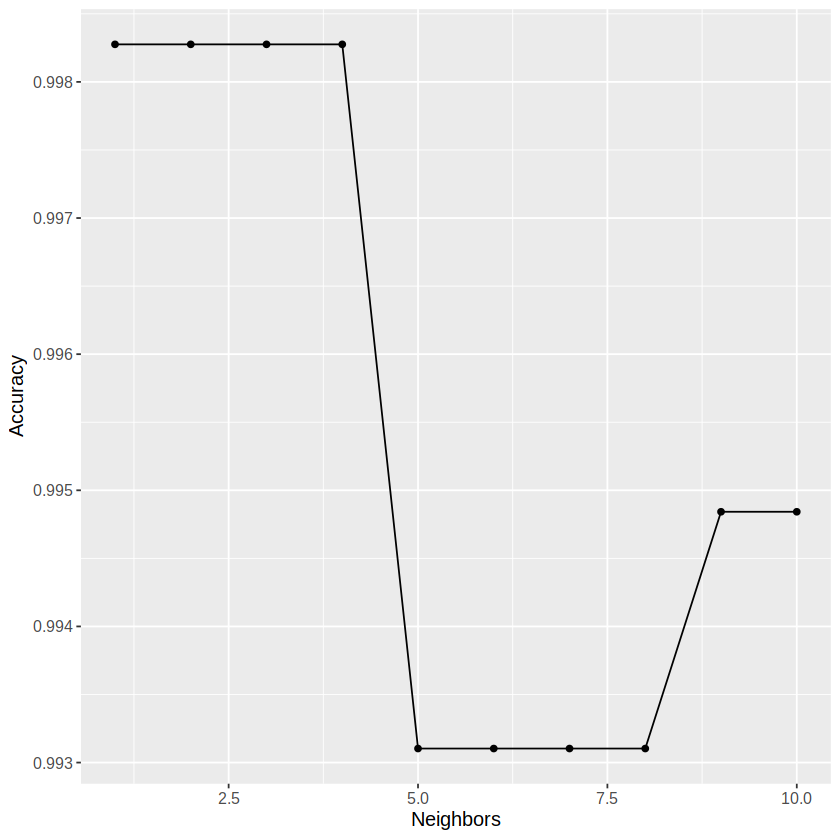

In [18]:
# A plot to visualize how accuracy changes as the number of neighbors (k) increases
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy") + 
  theme(text = element_text(size = 12))

accuracy_vs_k

The graph above is a representation of accuracy for each neighbor, showing the most accuracy for neighbors less than 2.5. This allows for us to check to see if the number of neighbors we chose to use will be accurate. While 3 neighbors may not be the most accurate, we will still use it because it still has a relatively high accuracy and using this odd number prevents ties between classification of "Not Suspicious" and "Suspicious".

**Methods**:


Our data analysis was centered around the 2 variables: Inherent_Risk, and Audit_Risk, which we used as  our predictors to classify whether a certain business is suspicious of fraudulence or not.

1) **Read Data**: The first step was to retrieve our audit data from the web. [find out how to drag data from the web into the Jupyter file]. We then used the function read_csv to allow Jupyter access to the data from the web so we can manipulate it.
2) **Wrangling the Data**: we mutated the “Risk” column to the format of a factor in order to classify the outcome of our analysis as either “Suspicious” if the Risk is equal to 1,  or “Not Suspicious” if the risk is equal to 0. We changed Location_ID to the format of a factor, as there are only 37 different locations so it is easier to classify them as a category. “LOCATION_ID” was changed to “Location_ID” just to improve overall readability. These changes were defined under audit_data.
3) **Tidying the Data**: We first selected our two predictors: Location_ID, Inherent_Risk, and Audit_Risk as we observed in the data table that they had the most influence and contribution to overall Risk. The locations “SAFIDON”, “NUH”, and “LOHARU” were filtered out as they were shown to be anomalies and did not fit the format of the other locations. These changes were defined under the name focused_audit_data. We used only Inherent_Risk and Audit_Risk because they were the sum of all the individual risk factors (labelled in the initial data from Risk_A to Risk_F) combined.
4) **Splitting the Data**: We split the data into an audit_training set and an audit_testing set, with 75% of the data falling into the training set and the remaining 25% being the testing set. This data was carefully split based on their classification of Risk to make sure there was an even distribution between the training set and the testing set. These guidelines were defined under audit_data_split. 
5) **Preliminary Exploratory Data Analysis**: The data was grouped by the Location_ID and the overall Risk classification in order to understand the number of suspicious and not suspicious businesses were found in each location. This helps to understand which locations are associated with the most fraudulence, which will help us determine how much location is associated with fraudulence. The data from this table was plotted to visualize the relationship between location and risk, defined under the name location_risk_plot.
6) **Data Analysis 2**: In order to observe the relationship between the Inherent_Risk predictor and overall fraudulent risk, we grouped the data by overall classification of risk, then calculated the average inherent risk, using the mean function, for the businesses classified as “Suspicious” and “Not Suspicious”. This analysis was plotted under the name inherent_vs_risk_plot
7) **Data Analysis 3**: To analyze the relationship between Audit_Risk and overall fraudulence risk, we grouped by the classification of overall risk. Then calculated the average audit risk, using the mean function, of the “Suspicious” businesses and the “Not Suspicious” businesses. This analysis was visualized and plotted under the name audit_risk_vs_risk_plot.
8) **Nearest Neighbours Classification Model**: Using the 3 predictors, Location_ID, Audit_Risk, and Inherent_Risk, we identified the threshold in which businesses are classified as “Suspicious” or “Not Suspicious”. Using 5 neighbours to classify, as it is a large enough number for accuracy, and odd so we do not get a tie between the contribution of predictors.
9) **Tuning the Classifier**: Using cross-validation, we split the training data into 5 "folds" to assess the accuracy of multiple classifiers to ensure the one we created is accurate. We then analyzed if our initial number of neighbors, k = 3, was accurate enough to build our classifier.
10) **Accuracy**: The Confusion matrix was used to assess how accurate the predictions in the model. The accuracy was also measured using the metrics function. 
  

We noticed that the higher the inherent and audit risk, the more likely the classified risk was suspicious. These factors can be taken into account when classifying a new observation risk.

Using mostly bar graphs, we were able to compare differences and identify trends that classify risks as either being suspicious or not suspicious. Each of our predictors showed plausible trends and significant relationships between the classified risk. Therefore, these have been validated as appropriate predictors to use in our classification model.

**Expected outcomes and significance:**

In our previous test with our classification model we used a new business with an inherent risk of 5 and an audit risk of 2.18. These risks are both considered the threshold for suspicious activity. Therefore, we would expect this new business to be classified as Suspicious. This expectation was proven to be correct, shown from the result of our predict_new_business test. Overall, we would expect to find new observations with high audit risks and high inherent risks to be classified as suspicious.

After testing the accuracy of our models, it showed that there was only one mislabelled observation, which was supposed to be labelled as "Not Suspicious" but was classified as "Suspicious" as shown in the confusion matrix. Therefore, our accuracy calculated from prediction_accuracy validates that our model is 99.4% accurate from our testing data prediction. With this, we can be confident that our classification model is reliable and that our prediction for our new business is likely accurate.


If our expectations are proven to be correct, then we could make further inferences about future observations and their classifications just based off of these two predictors alone. Identifying fraudulence would also be much more efficient if these predictors are enough to identify it.


Future Questions:

1) What is the threshold of audit and inherent risk that would result in the classification of risk being suspicious?
2) Why are certain location_IDs associated with more suspicious activity concerning fraudulence?
3) Are there other risks that influence classification of risk that were not present in this data?

**References**

Hooda, Nishtha. Audit Data. 2018. UCI Machine Learning Repository, https://doi.org/10.24432/C5930Q.
 
Tuovila, Alicia. “Auditor's Report: Necessary Components and Examples.” Investopedia, 1 January 2022, https://www.investopedia.com/terms/a/audit-risk.asp.
 
Tuovila, Alicia. “Inherent Risk: Definition, Examples, and 3 Types of Audit Risks.” Investopedia, 12 October 2023, https://www.investopedia.com/terms/i/inherent-risk.asp.